### Convolutional Neural Network

**Author: rNLKJA**

This notebook contains the code & notes for YouTube Video [Convolutional Neural Network from Scratch | Mathematics & Python Code](https://www.youtube.com/watch?v=Lakz2MoHy6o&t=276s).

You may also find the original codes on [Github](https://github.com/TheIndependentCode/Neural-Network).

I might add some notation for better understanding of How Convolution Neural Network works.

And I suggest you have a look on Neural Network notebook for better understanding.

**Kernel**

In CNN, the kernel is a filter, which a kernel will generate a new output by cross-correlation.

In math, the Convolution is expressed as $I * K = I * rot 180 (K)$

**Valid cross-correlation**

Applied kernel transform to each matrix but not hitting any boarder.

**Full cross-correlation**

Calculate kernel value for each matrix entry, but in this case, the size will increase since we calculate value outside the data matrix.

**Forward Propagation**

$$
\begin{bmatrix}
    Y_1 = B_1 + X_1 \star K_{11} + \dots + X_n \star K_{1n} \\
    Y_2 = B_2 + X_1 \star K_{21} + \dots + X_n \star K_{2n} \\
    \vdots \\
    Y_d = B_d + X_1 \star K_{d1} + \dots + X_n \star K_{dn}
\end{bmatrix} \\ Y_i = B_i + \sum^n_{j=1}X_j \star K_{ij}, i = 1\dots d
$$

$\star$ represents the cross-correlation.

$b$ represents the _depth_ of input.

**Backward Propagation**

We need to calculate $\cfrac{\partial E}{\partial K_{ij}}$, $\cfrac{\partial E}{\partial B_{i}}$ and $\cfrac{\partial E}{\partial X_{j}}$ to update the parameters in CNN.

$Y = B + X\star K \Rightarrow \cfrac{\partial{E}}{\partial K} = X \star \cfrac{\partial E}{\partial Y}$

$Y=B+X*K\Rightarrow \cfrac{\partial E}{\partial B}=\cfrac{\partial E}{\partial Y}$

$Y=B+X\star K \Rightarrow \cfrac{\partial E}{\partial X} = \cfrac{\partial E}{\partial Y}\star_{full}K$

In [4]:
import numpy as np
from tqdm import tqdm
from scipy import signal

In [3]:
# the base layer code is adapted from the Neural Network Notebook
# implmenet the base layer
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    # a forward method takes the input to produce the output
    def forward(self, input):
        # TODO: return output
        pass
    
    # the backward method takes the output to update its input
    # 1. update the training parameters
    # 2. return the derivative of error based on the learning rate
    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [16]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height-kernel_size+1, 
                                    input_width-kernel_size+1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [5]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [6]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [7]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [8]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [9]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [10]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [11]:
from keras.datasets import mnist
from keras.utils import np_utils

In [12]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

In [13]:
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

11501568/11490434 [==============================] - 1s 0us/step


In [17]:
# neural network
neural_network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

In [19]:
# train
train(
    neural_network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

1/20, error=0.42720470367585534
2/20, error=0.12332058714025786
3/20, error=0.05687849496976222
4/20, error=0.060353368465701676
5/20, error=0.04780772851249701
6/20, error=0.041250207871764234
7/20, error=0.027703682382603612
8/20, error=0.016577769755288504
9/20, error=0.02116051085203891
10/20, error=0.01073188835885614
11/20, error=0.007931861256089514
12/20, error=0.006614308839821555
13/20, error=0.005569598371420242
14/20, error=0.004790048958928143
15/20, error=0.00442070000220764
16/20, error=0.0043193258308285324
17/20, error=0.0037462257937617887
18/20, error=0.00352881564665587
19/20, error=0.003267057955892115
20/20, error=0.003074047882638469


In [37]:
# test
pred, true = [], []
for x, y in zip(x_test, y_test):
    output = predict(neural_network, x)
    pred.append(np.argmax(output))
    true.append(np.argmax(y))
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true:

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot:>

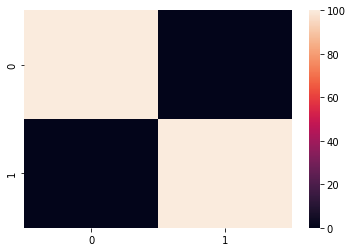

In [39]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm)